In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
sns.set()

In [26]:
class ParticleFilter(object):
    def __init__(self, n_states, n_particles=1000, resample=True):
        super(ParticleFilter, self).__init__()
        self.n_particles = n_particles
        self.n_states = n_states
        self.resample = resample
        self.particles = None
        self.importances = np.ones(n_particles) / n_particles

    def init_uniform(self, low, high):
        self.particles = np.random.uniform(low, high, (self.n_particles, self.n_states))

    def init_normal(self, mean, covariance):
        A = np.linalg.cholesky(covariance)
        self.particles = np.random.randn(self.n_particles, self.n_states) @ A.T + mean

    def sample_particle(self, particle, **kwargs):
        """
        Sampling a particle from P(x_{n} | x_{n-1; kwargs}=particle)
        """
        raise NotImplementedError

    def update_importance(self, zn, particle, importance, **kwargs):
        """
        Updating the importance by
        importance_i=P(z_{n}=zn | x_{n}=particle_i; kwargs) * importance_i
        """
        raise NotImplementedError

    def filter(self, zn, **kwargs):
        """
        :param zn: observed value at time step n
        :param kwargs: parameters in process model and observation model
        :return: estimation, particles, importances
        """
        self.particles = np.array(list(map(partial(self.sample_particle, **kwargs),
                                           self.particles)))

        self.importances = np.array(list(map(partial(self.update_importance, zn, **kwargs),
                                             self.particles, self.importances)))

        self.importances = self.importances / sum(self.importances)
        estimation = self.importances @ self.particles
        importances = self.importances

        if self.resample:
            index = np.random.choice(range(self.n_particles),
                                     size=self.n_particles, p=self.importances)
            self.particles = self.particles[index]
            self.importances = np.ones(self.n_particles) / self.n_particles

        return estimation, self.particles, importances

## Particle Filter for Online Parameter Estimation ##

-1.9360871391703698 1.9891132540277128


<AxesSubplot:>

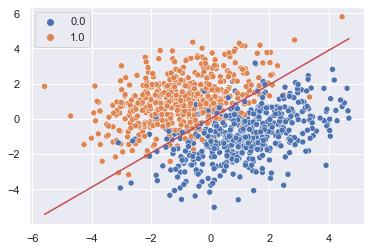

In [16]:
np.random.seed(42)

N1, N2 = 500, 500
alpha = 1.0
covariance = [[2, 1], [1, 2]]
A = np.linalg.cholesky(covariance)
X1 = np.random.randn(2, N1)
X2 = np.random.randn(2, N2)
X1 = (A @ X1).T + np.array([-alpha, alpha])
X2 = (A @ X2).T + np.array([alpha, -alpha])
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((np.ones(N1), np.zeros(N2)))
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

model = LogisticRegression(penalty='none', tol=1e-4, fit_intercept=False)
model.fit(X, y)
theta1, theta2 = model.coef_[0]
print(theta1, theta2)

bound_x = np.linspace(min(X[:, 0]), max(X[:, 0]))
bound_y = -theta1 / theta2 * bound_x

plt.figure()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.lineplot(x=bound_x, y=bound_y, color='r')

In [18]:
# np.random.seed(42)

def sample_particle(particle, **kwargs):
    # process model: Gaussian distribution
    sigma = kwargs.get('sigma', 0.001)
    return particle + sigma**0.5 * np.random.randn(*particle.shape)


def update_importance(zn, particle, importance, **kwargs):
    # obersevation model: Bernoulli distribution
    fx = particle @ kwargs.get('xn')
    if fx >= 0:
        p = 1 / (1 + np.exp(-fx))
    else:
        p = np.exp(fx) / (1 + np.exp(fx))
    return p**zn * (1 - p)**(1 - zn) * importance


pf = ParticleFilter(2, n_particles=1000, resample=True)
# pf.init_normal([0, 0], [[100, 0], [0, 100]])
pf.init_uniform([-1, -1], [1, 1])
pf.sample_particle = sample_particle
pf.update_importance = update_importance

estimation_hist = np.zeros((len(X), 2))
particles_hist = []
importances_hist = []
for n, (xn, yn) in enumerate(zip(X, y)):
    estimation, particles, importances = pf.filter(yn, xn=xn, sigma=0.001)
    estimation_hist[n] = estimation
    if n == 0 or n == int(len(X) * 0.25) - 1 or n == int(len(X) * 0.5) - 1 or\
            n == int(len(X) * 0.75) - 1 or n == len(X) - 1:
        particles_hist.append((n + 1, particles))
        importances_hist.append((n + 1, importances))

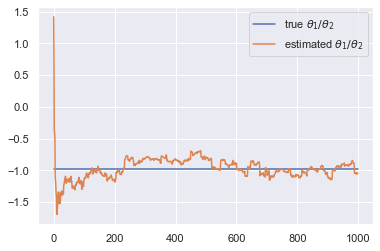

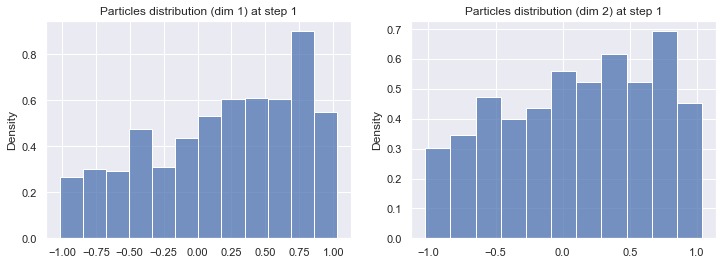

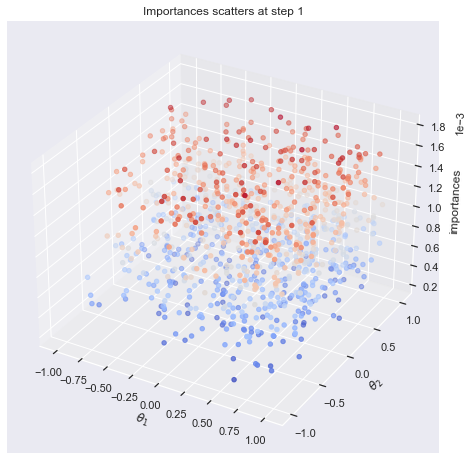

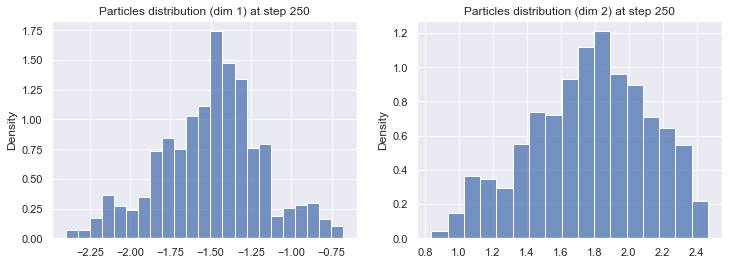

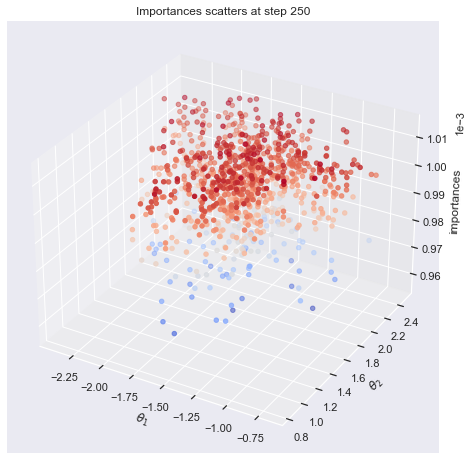

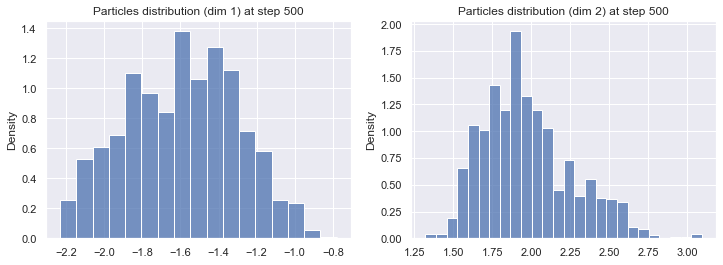

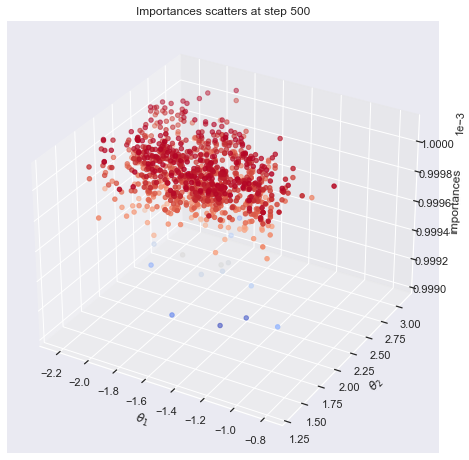

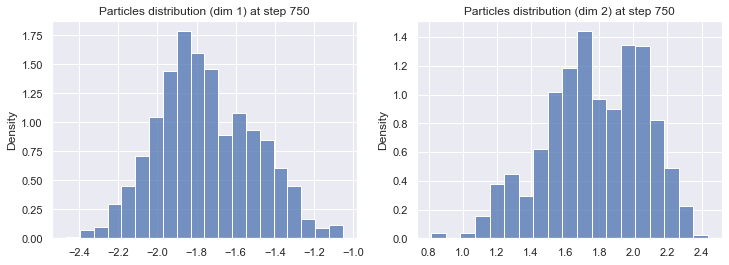

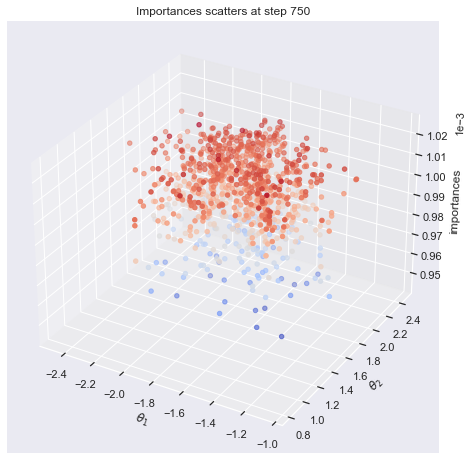

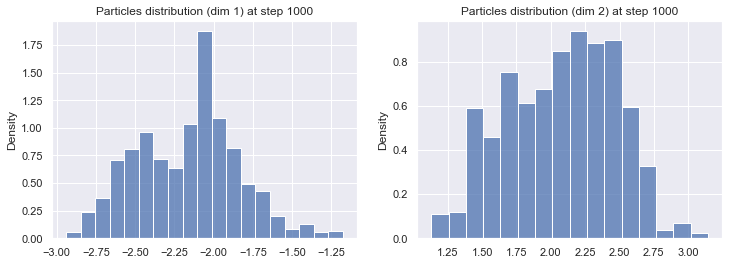

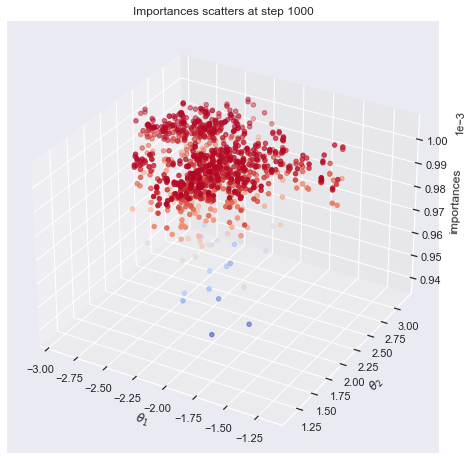

In [19]:
plt.figure()
sns.lineplot(x=range(len(estimation_hist)), y=theta1 / theta2, label=r'true $\theta_1/\theta_2$')
sns.lineplot(x=range(len(estimation_hist)), y=estimation_hist[:, 0] / estimation_hist[:, 1], label=r'estimated $\theta_1/\theta_2$')
# plt.savefig('figures/lr_pf_alpha20.jpg')

for i in range(len(particles_hist)):
    fig = plt.figure(figsize=(12, 4))
    fig.add_subplot(1, 2, 1)
    ax = sns.histplot(data=particles_hist[i][1][:, 0], stat='density')
    ax.set_title('Particles distribution (dim 1) at step {}'.format(particles_hist[i][0]))

    fig.add_subplot(1, 2, 2)
    ax = sns.histplot(data=particles_hist[i][1][:, 1], stat='density')
    ax.set_title('Particles distribution (dim 2) at step {}'.format(particles_hist[i][0]))

    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    ax.scatter(particles_hist[i][1][:, 0], particles_hist[i][1][:, 1],
               importances_hist[i][1], marker='o',
               c=importances_hist[i][1], cmap=cm.coolwarm)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel('importances')
    ax.set_title('Importances scatters at step {}'.format(particles_hist[i][0]))
    ax.zaxis.get_major_formatter().set_powerlimits((0, 1))

## Particle Filter on Autoregressive Problem ##
$ x_n=\theta_1^{(n)}x_{n-1}+\theta_2^{(n)}x_{n-2}+\epsilon_n $

In [32]:
# Length of time series
N = 1500

# Gaussian random numbers as an excitation signal
np.random.seed(42)
ex = np.random.randn(N)

# Second order AR Process
a0 = np.array([1.2, -0.4])
A = np.zeros((N, 2))
alpha = 0.1

for n in range(N):
    A[n, 0] = a0[0] + alpha * np.cos(10 * np.pi * n / N)
    A[n, 1] = a0[1] + alpha * np.sin(6 * np.pi * n / N)

x = ex.copy()
for n in range(2, N):
    x[n] = np.array([x[n - 1], x[n - 2]]) @ A[n] + ex[n]

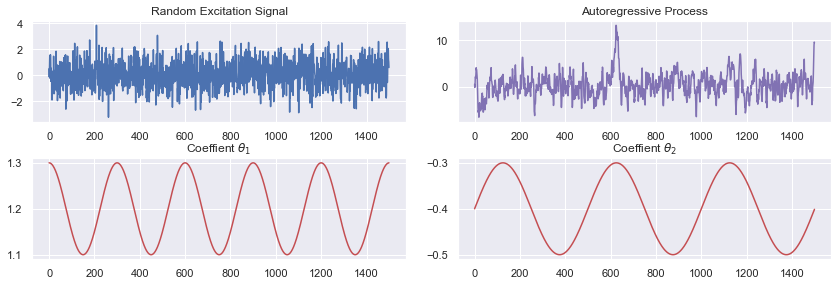

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))

plt.tight_layout()

ax[0][0].plot(range(N), ex)
ax[0][0].set_title("Random Excitation Signal")

ax[0][1].plot(range(N), x, color='m')
ax[0][1].set_title("Autoregressive Process")

ax[1][0].plot(A[:, 0], color='r')
ax[1][0].set_title(r"Coeffient $\theta_1$")

ax[1][1].plot(A[:, 1], color='r')
ax[1][1].set_title(r"Coeffient $\theta_2$")

plt.savefig('figures/ap_data_varying.jpg')

### SIS Filter ###

In [34]:
np.random.seed(42)


def sample_particle(particle, **kwargs):
    # process model: Gaussian distribution
    sigma = kwargs.get('sigma1', 0.001)
    return particle + sigma**0.5 * np.random.randn(*particle.shape)


def update_importance(zn, particle, importance, **kwargs):
    # obersevation model: Gaussian distribution
    sigma = kwargs.get('sigma2', 1)
    xn1, xn = kwargs['xn1'], kwargs['xn']
    return np.exp(-(zn - particle @ [xn1, xn])**2 / (2 * sigma**2)) * importance


pf = ParticleFilter(2, resample=False)
pf.init_normal([0, 0], [[1, 0], [0, 1]])
pf.sample_particle = sample_particle
pf.update_importance = update_importance

estimation_hist = np.zeros((len(x) - 2, 2))
particles_hist = []
importances_hist = []
for n in range(len(x) - 2):
    estimation, particles, importances = pf.filter(x[n + 2], xn1=x[n + 1], xn=x[n])
    estimation_hist[n] = estimation
#     if n == 0 or n == int(len(x) / 3) - 1 or n == int(len(x) * 2 / 3) - 1 or\
#             n == len(x) - 3:
    if n == 0 or n == 2 or n == 5 or n == 19:
        particles_hist.append((n + 1, particles))
        importances_hist.append((n + 1, importances))

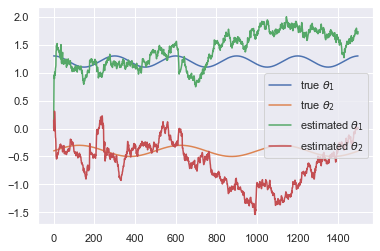

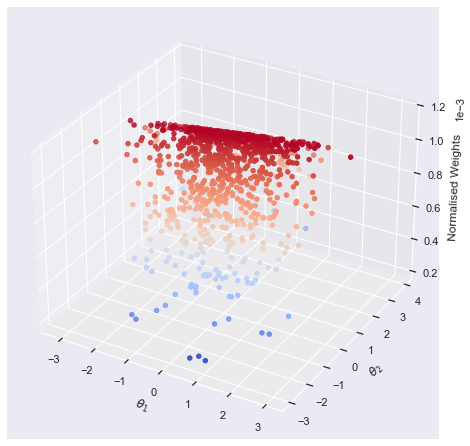

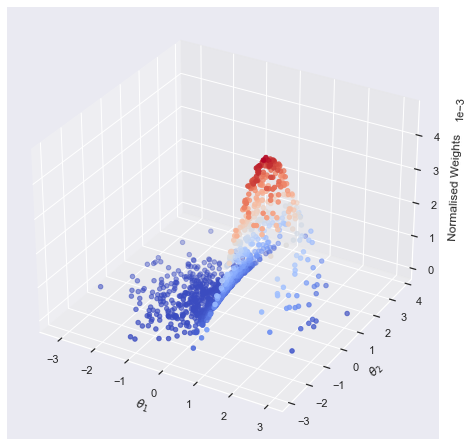

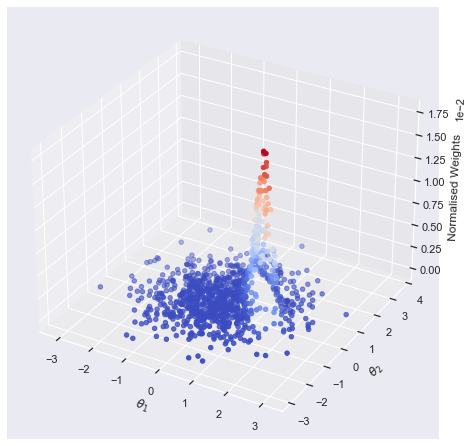

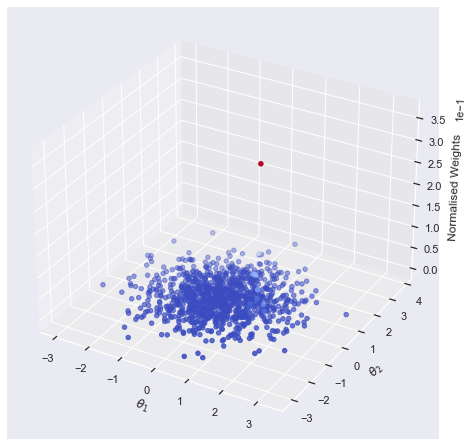

In [35]:
plt.figure()
sns.lineplot(x=range(len(estimation_hist)), y=A[:len(estimation_hist), 0], label=r'true $\theta_1$')
sns.lineplot(x=range(len(estimation_hist)), y=A[:len(estimation_hist), 1], label=r'true $\theta_2$')
sns.lineplot(x=range(len(estimation_hist)), y=estimation_hist[:, 0], label=r'estimated $\theta_1$')
sns.lineplot(x=range(len(estimation_hist)), y=estimation_hist[:, 1], label=r'estimated $\theta_2$')
# plt.savefig('figures/ap_sis_estimation.jpg')

for i in range(len(particles_hist)):
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    ax.scatter(particles_hist[i][1][:, 0], particles_hist[i][1][:, 1],
               importances_hist[i][1], marker='o',
               c=importances_hist[i][1], cmap=cm.coolwarm)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel('Normalised Weights')
#     ax.set_title('Importances scatters at step {}'.format(particles_hist[i][0]))
    ax.zaxis.get_major_formatter().set_powerlimits((0, 1))

#     plt.savefig('figures/ap_sis_importances_step_{}.jpg'.format(particles_hist[i][0]), bbox_inches='tight')

### SIR Filter ###

In [37]:
pf = ParticleFilter(2, resample=True)
pf.init_normal([0, 0], [[1, 0], [0, 1]])
pf.sample_particle = sample_particle
pf.update_importance = update_importance

estimation_hist = np.zeros((len(x) - 2, 2))
particles_hist = []
importances_hist = []
for n in range(len(x) - 2):
    estimation, particles, importances = pf.filter(x[n + 2], xn1=x[n + 1], xn=x[n])
    estimation_hist[n] = estimation
#     if n == 0 or n == int(len(x) / 3) - 1 or n == int(len(x) * 2 / 3) - 1 or\
#             n == len(x) - 3:
    if n == 0 or n == 2 or n == 5 or n == 19:
        particles_hist.append((n + 1, particles))
        importances_hist.append((n + 1, importances))

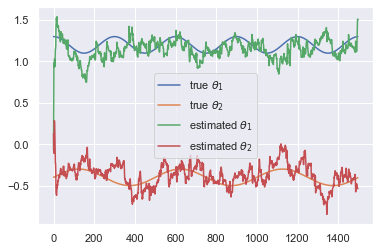

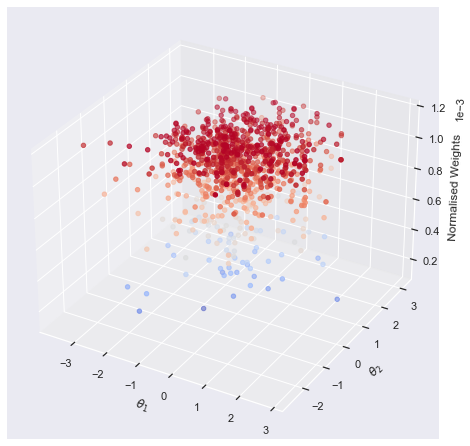

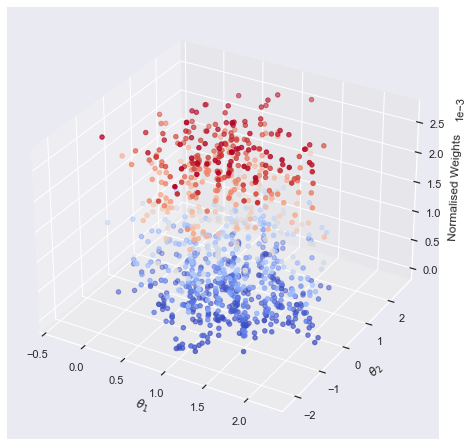

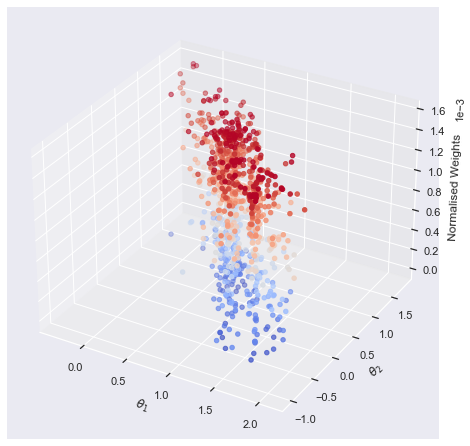

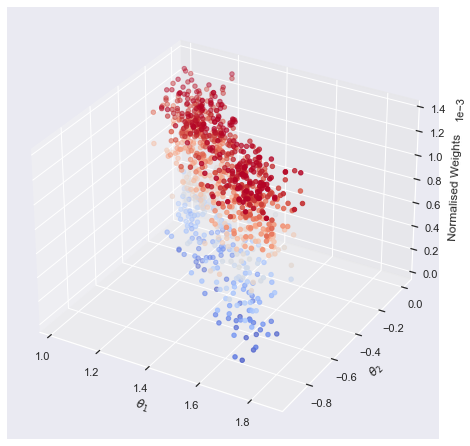

In [38]:
plt.figure()
sns.lineplot(x=range(len(estimation_hist)), y=A[:len(estimation_hist), 0], label=r'true $\theta_1$')
sns.lineplot(x=range(len(estimation_hist)), y=A[:len(estimation_hist), 1], label=r'true $\theta_2$')
sns.lineplot(x=range(len(estimation_hist)), y=estimation_hist[:, 0], label=r'estimated $\theta_1$')
sns.lineplot(x=range(len(estimation_hist)), y=estimation_hist[:, 1], label=r'estimated $\theta_2$')
# plt.savefig('figures/ap_sir_estimation.jpg')

for i in range(len(particles_hist)):
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig)
    ax.scatter(particles_hist[i][1][:, 0], particles_hist[i][1][:, 1],
               importances_hist[i][1], marker='o',
               c=importances_hist[i][1], cmap=cm.coolwarm)
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel('Normalised Weights')
#     ax.set_title('Importances scatters at step {}'.format(particles_hist[i][0]))
    ax.zaxis.get_major_formatter().set_powerlimits((0, 1))

#     plt.savefig('figures/ap_sir_importances_step_{}.jpg'.format(particles_hist[i][0]), bbox_inches='tight')